# thal2 1:1 Bifurcation Diagrams

# Inits

## Imports

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [3]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [4]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [5]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [6]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [8]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [9]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [10]:
system1 = rsp(idx=0,model_name='thal0_85',**kws1)
system2 = rsp(idx=1,model_name='thal1_85',**kws1)

mkdir ./data/thal0_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/thal1_85/
* Loading LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.024354475778909167
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# Initialize Coupling 1:1

In [11]:
het_coeffs = [1,100]

In [12]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (1,1)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 11 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

In [13]:
etup = (.001,.2,100)

<Axes: >

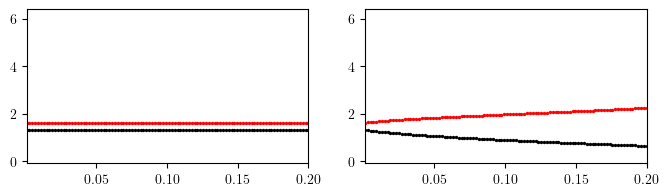

In [14]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.025,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

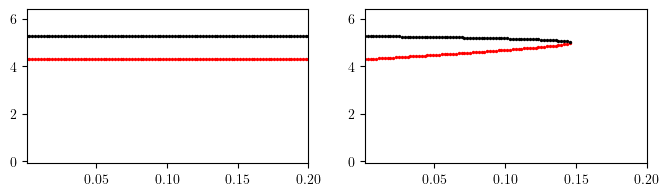

In [15]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=.02,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=.01,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

# for i in range(2):
#     draw_quick_plot_f(axs[i],data_b1_list,a)

In [16]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=0,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [17]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.028,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

In [18]:
# fig,axs = plt.subplots(1,2,figsize=(8,2))
# kw_diagram = dict(a=a,b=-.04,eps_tup=etup,rhs=_redu_c2)
# add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
# add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

<Axes: >

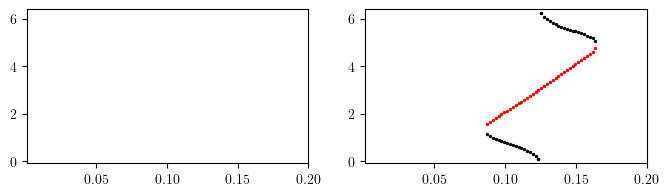

In [19]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=-.08,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

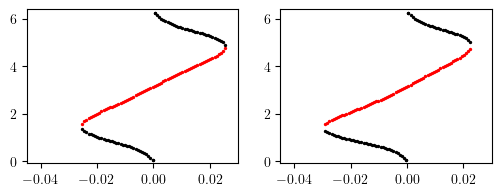

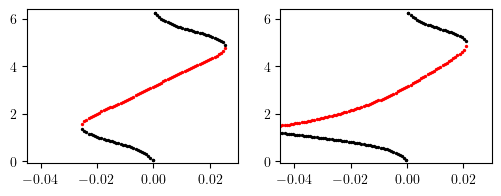

In [20]:
dtup11 = (-.045,.03,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup11,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup11,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)


#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

### Sims and Plot

In [21]:
# dat1,dat2=load_sol_all(a=a,eps=0.075,phi0=6,b=-.05,T=2000,recompute=True)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]#;so3=dat2[:,3];so4=dat2[:,4]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

## EPS VARY

In [22]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [23]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [24]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.024

#### Branches eps stable

In [25]:
b=0.024
kw_b['recompute'] = False
kw_b['b'] = b

In [26]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=1,eps_init=0.01,eps_final=0,deps=-.001),
    dict(phi0=1,eps_init=0.009,eps_final=0.05,deps=.001),
    dict(phi0=1,eps_init=0.049,eps_final=0.06,deps=.001)
]

In [27]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1
phi init 1


In [28]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [29]:
kw_b['recompute'] = False
kw_b['b'] = b

In [30]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [31]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4.5,eps_init=0.04,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4.5
phase_diffs_u_init=4.5_nm=11_b=0.024_ei=0.04_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.5_nm=11_b=0.024_ei=0.04_ef=0_de=-2.txt


In [32]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.04,eps_final=0,deps=-.003),
            dict(phi0=2,eps_init=0.039,eps_final=0.2,deps=.002),
           ]

In [33]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=0.024_ei=0.04_ef=0_de=-0.003.txt
phase_diffs_u_pt_init=2_nm=11_b=0.024_ei=0.04_ef=0_de=-0.003.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=0.024_ei=0.039_ef=0.2_de=0.002.txt
phase_diffs_u_pt_init=2_nm=11_b=0.024_ei=0.039_ef=0.2_de=0.002.txt


In [34]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

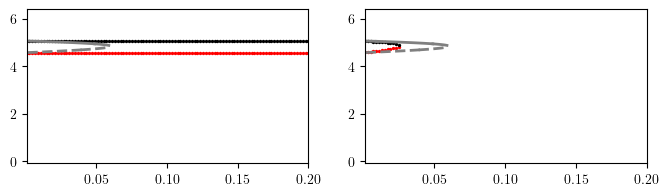

In [35]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [36]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.05900000000000002 4.79803576488465
phi init 4.79803576488465
Y [-0.10606774  0.23174507  0.09831572  0.40119695 -0.59875141  0.20383646  0.07697817  0.05848982  6.23608969]
mkdir ./data/thal2_11_b0=0.024/
* Loading LC data...
self.T 6.236092504597892
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0007084025853735135
es_min,phi0 0.05850000000000002 4.79803576488465
phi init 4.79803576488465
Y [-0.10605777  0.23159566  0.09827092  0.40137465 -0.59817181  0.20260262  0.0770754   0.059152    6.23706201]
mkdir ./data/thal2_11_b1=0.024/
* Loading LC data...
self.T 6.237065319982436
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.000823037138098945
es_min,phi0 0.05800000000000002 4.79803576488465
phi init 4.79803576488465
Y [-0.106056    0.22635761  0.09820561  0.40742174 -0.59826111  0.20285307  0.07719255  0.05901886  6.23794518]
mkdir ./data/thal2_11_b2=0.024/
* Loading LC data...
self.T 6.237948073251361
loaded

In [37]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.023

#### Branches eps stable

In [38]:
b=0.023
kw_b['recompute'] = False
kw_b['b'] = b

In [39]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.01)]

In [40]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [41]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [42]:
kw_b['recompute'] = False
kw_b['b'] = b

In [43]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [44]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4.5,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4.5
phase_diffs_u_init=4.5_nm=11_b=0.023_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.5_nm=11_b=0.023_ei=0.05_ef=0_de=-2.txt


In [45]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [46]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=0.023_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=11_b=0.023_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=0.023_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=11_b=0.023_ei=0.049_ef=0.2_de=0.01.txt


In [47]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

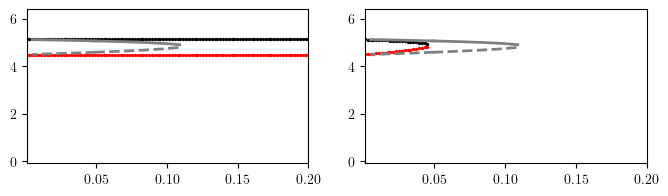

In [48]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys max

In [49]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.10900000000000001 4.900394662076853
phi init 4.900394662076853
Y [-0.10463836  0.22918858  0.10245572  0.40588261 -0.59298802  0.19822414  0.0667633   0.06100606  6.20789634]
mkdir ./data/thal2_11_b0=0.023/
* Loading LC data...
self.T 6.207898593146957
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.002064876973291314
es_min,phi0 0.10850000000000001 4.900394662076853
phi init 4.900394662076853
Y [-0.10463365  0.23108235  0.10241399  0.40372096 -0.59240739  0.19699829  0.06684772  0.06170955  6.2088416 ]
mkdir ./data/thal2_11_b1=0.023/
* Loading LC data...
self.T 6.2088438165509965
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0022011908445205047
es_min,phi0 0.10800000000000001 4.900394662076853
phi init 4.900394662076853
Y [-0.10465487  0.2334447   0.10237441  0.40101327 -0.59179087  0.19571033  0.0669319   0.062459    6.20973832]
mkdir ./data/thal2_11_b2=0.023/
* Loading LC data...
self.T 6.20974028994994


In [50]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=0.02

#### Branches eps stable

In [51]:
b=0.02
kw_b['recompute'] = False
kw_b['b'] = b

In [52]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.01)]

In [53]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [54]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [55]:
kw_b['recompute'] = False
kw_b['b'] = b

In [56]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [57]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=4.5,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 4.5
phase_diffs_u_init=4.5_nm=11_b=0.02_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=4.5_nm=11_b=0.02_ei=0.05_ef=0_de=-2.txt


In [58]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.049,eps_final=0.2,deps=.01),
           ]

In [59]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=0.02_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=11_b=0.02_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=0.02_ei=0.049_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=11_b=0.02_ei=0.049_ef=0.2_de=0.01.txt


In [60]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

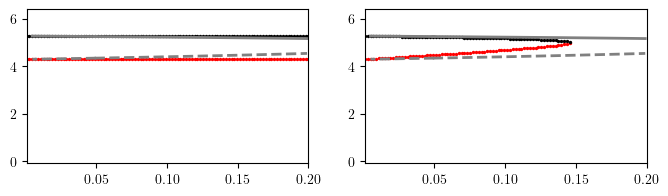

In [61]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [62]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.025

#### Branches eps stable

In [63]:
b=-.025
kw_b['recompute'] = False
kw_b['b'] = b

In [64]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.01)]

In [65]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [66]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [67]:
kw_b['recompute'] = False
kw_b['b'] = b

In [68]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [69]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.03,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.025_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.025_ei=0.03_ef=0_de=-2.txt


In [70]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.03,eps_final=0,deps=-.002),
            dict(phi0=2,eps_init=0.029,eps_final=0.2,deps=.01),
           ]

In [71]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.025_ei=0.03_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.025_ei=0.03_ef=0_de=-0.002.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=-0.025_ei=0.029_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.025_ei=0.029_ef=0.2_de=0.01.txt


In [72]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

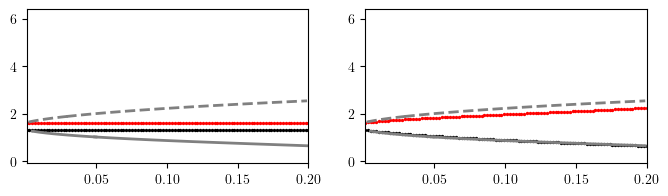

In [73]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [74]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.027

#### Sim

In [75]:
# a=a;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [76]:
# # show original system
# a=a;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [77]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [78]:
b=-.027
kw_b['recompute'] = False
kw_b['b'] = b

In [79]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.2,deps=.01)]

In [80]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [81]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [82]:
kw_b['recompute'] = False
kw_b['b'] = b

In [83]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [84]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.03,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.027_ei=0.03_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.027_ei=0.03_ef=0_de=-2.txt


In [85]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.03,eps_final=0,deps=-.002),
            dict(phi0=2,eps_init=0.029,eps_final=0.2,deps=.01),
           ]

In [86]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.027_ei=0.03_ef=0_de=-0.002.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.027_ei=0.03_ef=0_de=-0.002.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=-0.027_ei=0.029_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.027_ei=0.029_ef=0.2_de=0.01.txt


In [87]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

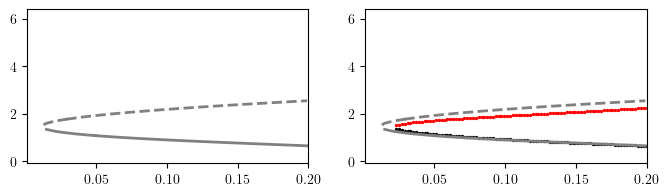

In [88]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [89]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.011999999999999983 1.4141482039988276
phi init 1.4141482039988276
Y [-1.09048797e-01  2.29826831e-01  9.00613195e-02  3.99829594e-01 -4.76957551e-01  6.52747369e-01  9.82706298e-02  6.44202939e-05  6.26128181e+00]
mkdir ./data/thal2_11_b0=-0.027/
* Loading LC data...
self.T 6.261286742179992
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0001736372056265711
es_min,phi0 0.012499999999999983 1.4141482039988276
phi init 1.4141482039988276
Y [-1.09104154e-01  2.30372300e-01  8.99145166e-02  3.99125522e-01 -4.75447635e-01  6.53364806e-01  9.82350218e-02  6.19589882e-05  6.26086166e+00]
mkdir ./data/thal2_11_b1=-0.027/
* Loading LC data...
self.T 6.260863362797725
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0002670332589221253
es_min,phi0 0.012999999999999984 1.4141482039988276
phi init 1.4141482039988276
Y [-1.09163130e-01  2.25234428e-01  8.97472975e-02  4.05124797e-01 -4.73800847e-01  6.54002599e-01  9.8195

In [90]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.028

#### Sim

In [91]:
# a=a;T=5000;b=0.007;e=.038;phi0 = 4
# dat1,dat2=load_sol_all(a=a,eps=e,phi0=phi0,b=b,T=T,recompute=False)
# t1=dat1[:,0];y=dat1[:,1]
# t2=dat2[:,0];so1=dat2[:,1];so2=dat2[:,2]

# fig,axs = plt.subplots(figsize=(4,2))

# axs.scatter(t1,y,s=1,alpha=.5,color='black')

# axs.plot(t2,np.mod(so1,2*np.pi),label='o1')
# axs.plot(t2,np.mod(so2,2*np.pi),label='o2')

# axs.set_ylim(-.5,2*np.pi+.5)
# axs.legend()

##### Original

In [92]:
# # show original system
# a=a;T=1000;b=0.007;e=.02;phi0 = 4
# solf, solr_o1, solr_o2 = compute_sol_all(a,e,phi0,b,T=T,dt=.01)

In [93]:
# fig,axs = plt.subplots(figsize=(4,2))
# axs.plot(solf.t,solf.y[0])
# # axs.plot(solf.t,solf.y[3])
# axs.plot(solf.t,solf.y[4])
# axs.set_xlim(800,1000)

#### Branches eps stable

In [94]:
b=-.028
kw_b['recompute'] = False
kw_b['b'] = b

In [95]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.05,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.049,eps_final=0.1,deps=.005),
            dict(phi0=1,eps_init=0.099,eps_final=0.2,deps=.01)
           ]

In [96]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1
phi init 1


In [97]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [98]:
kw_b['recompute'] = False
kw_b['b'] = b

In [99]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [100]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.028_ei=0.05_ef=0_de=-2.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.028_ei=0.05_ef=0_de=-2.txt


In [101]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.05,eps_final=0,deps=-.005,use_point=Yinit),
            dict(phi0=2,eps_init=0.049,eps_final=0.1,deps=.005,use_point=Yinit),
            dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.01,use_point=Yinit),
           ]

In [102]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.028_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.028_ei=0.05_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=-0.028_ei=0.049_ef=0.1_de=0.005.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.028_ei=0.049_ef=0.1_de=0.005.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=-0.028_ei=0.099_ef=0.2_de=0.01.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.028_ei=0.099_ef=0.2_de=0.01.txt


In [103]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

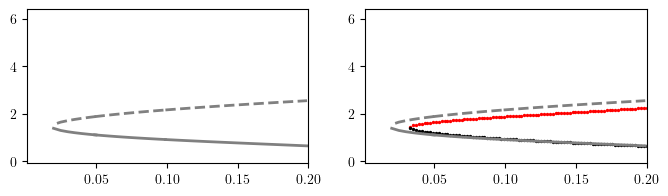

In [104]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [105]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.020000000000000018 1.3801286036448897
phi init 1.3801286036448897
Y [-1.10078192e-01  2.29613593e-01  8.76352380e-02  3.98882547e-01 -4.74958061e-01  6.53452385e-01  9.84048413e-02  6.14871766e-05  6.24804668e+00]
mkdir ./data/thal2_11_b0=-0.028/
* Loading LC data...
self.T 6.248048446514631
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0005205358146950771
es_min,phi0 0.020500000000000018 1.3801286036448897
phi init 1.3801286036448897
Y [-1.10117877e-01  2.27172495e-01  8.74865738e-02  4.01730644e-01 -4.73711507e-01  6.53933335e-01  9.83769049e-02  5.95794911e-05  6.24769714e+00]
mkdir ./data/thal2_11_b1=-0.028/
* Loading LC data...
self.T 6.2476988862583225
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0006286955644751704
es_min,phi0 0.02100000000000002 1.3801286036448897
phi init 1.3801286036448897
Y [-1.10166971e-01  2.28710744e-01  8.73535111e-02  3.99845977e-01 -4.72987545e-01  6.54209643e-01  9.8364

In [106]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.04

#### Branches eps stable

In [107]:
b=-.04
kw_b['recompute'] = False
kw_b['b'] = b

In [108]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.109,eps_final=0.21,deps=.01)]

In [109]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [110]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [111]:
kw_b['recompute'] = False
kw_b['b'] = b

In [112]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [113]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.1,eps_init=0.12,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.1
phase_diffs_u_init=2.1_nm=11_b=-0.04_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.1_nm=11_b=-0.04_ei=0.12_ef=0_de=-2.txt


In [114]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2,eps_init=0.12,eps_final=0,deps=-.005),
            dict(phi0=2,eps_init=0.119,eps_final=0.21,deps=.01),
           ]

In [115]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2
phase_diffs_u_init=2_nm=11_b=-0.04_ei=0.12_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.04_ei=0.12_ef=0_de=-0.005.txt
phi init 2
phase_diffs_u_init=2_nm=11_b=-0.04_ei=0.119_ef=0.21_de=0.01.txt
phase_diffs_u_pt_init=2_nm=11_b=-0.04_ei=0.119_ef=0.21_de=0.01.txt


In [116]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

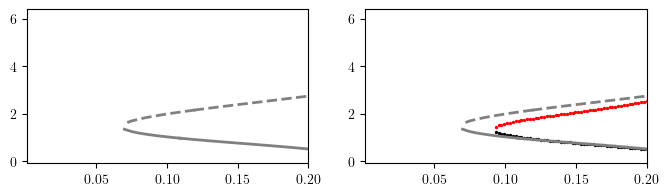

In [117]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [118]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.06999999999999995 1.5784213032631316
phi init 1.5784213032631316
Y [-1.16500565e-01  2.22214000e-01  7.39349080e-02  4.00257539e-01 -4.75053827e-01  6.52664845e-01  9.95913172e-02  6.37891654e-05  6.16700626e+00]
mkdir ./data/thal2_11_b0=-0.04/
* Loading LC data...
self.T 6.1670068391834185
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0028422570362704605
es_min,phi0 0.07049999999999995 1.5784213032631316
phi init 1.5784213032631316
Y [-1.16490606e-01  2.22426797e-01  7.38554338e-02  3.99998904e-01 -4.74037066e-01  6.53084060e-01  9.95631824e-02  6.21403836e-05  6.16791909e+00]
mkdir ./data/thal2_11_b1=-0.04/
* Loading LC data...
self.T 6.167919664627204
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.0032089752716432563
es_min,phi0 0.07099999999999995 1.5784213032631316
phi init 1.5784213032631316
Y [-1.16481923e-01  2.29394885e-01  7.37983332e-02  3.91328039e-01 -4.73871321e-01  6.53206941e-01  9.95583670

In [119]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.06

#### Branches eps stable

In [120]:
b=-.06
kw_b['recompute'] = False
kw_b['b'] = b

In [121]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.109,eps_final=0.21,deps=.01)]

In [122]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [123]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [124]:
kw_b['recompute'] = False
kw_b['b'] = b

In [125]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [126]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.3,eps_init=0.12,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.3
phase_diffs_u_init=2.3_nm=11_b=-0.06_ei=0.12_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.3_nm=11_b=-0.06_ei=0.12_ef=0_de=-2.txt


In [127]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.3,eps_init=0.12,eps_final=0,deps=-.005),
            dict(phi0=2.3,eps_init=0.119,eps_final=0.21,deps=.01),
           ]

In [128]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.3
phase_diffs_u_init=2.3_nm=11_b=-0.06_ei=0.12_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2.3_nm=11_b=-0.06_ei=0.12_ef=0_de=-0.005.txt
phi init 2.3
phase_diffs_u_init=2.3_nm=11_b=-0.06_ei=0.119_ef=0.21_de=0.01.txt
phase_diffs_u_pt_init=2.3_nm=11_b=-0.06_ei=0.119_ef=0.21_de=0.01.txt


In [129]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

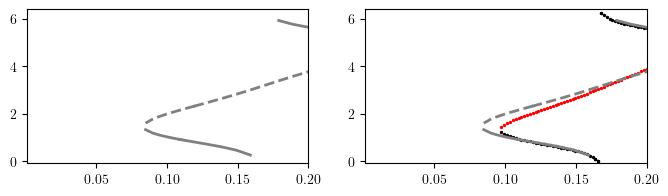

In [130]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [131]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.08499999999999996 1.597597862287289
phi init 1.597597862287289
Y [-1.18286707e-01  2.22808312e-01  7.03454989e-02  3.97302557e-01 -4.74678708e-01  6.52625612e-01  9.99088566e-02  6.37394436e-05  6.14575448e+00]
mkdir ./data/thal2_11_b0=-0.06/
* Loading LC data...
self.T 6.145755403022119
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004075447513340859
es_min,phi0 0.08549999999999996 1.597597862287289
phi init 1.597597862287289
Y [-1.18195570e-01  2.27092783e-01  7.03396759e-02  3.91995292e-01 -4.73472342e-01  6.53167322e-01  9.98632080e-02  6.16541153e-05  6.14827598e+00]
mkdir ./data/thal2_11_b1=-0.06/
* Loading LC data...
self.T 6.14827638704909
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.00478355357858329
es_min,phi0 0.08599999999999997 1.597597862287289
phi init 1.597597862287289
Y [-1.18127693e-01  2.26541853e-01  7.03205303e-02  3.92770039e-01 -4.71913785e-01  6.53780062e-01  9.98095963e-02  5.926

In [132]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.08

#### Branches eps stable

In [133]:
b=-.08
kw_b['recompute'] = False
kw_b['b'] = b

In [134]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.109,eps_final=0.21,deps=.01)]

In [135]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [136]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [137]:
kw_b['recompute'] = False
kw_b['b'] = b

In [138]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [139]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=2.5,eps_init=0.11,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 2.5
phase_diffs_u_init=2.5_nm=11_b=-0.08_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=2.5_nm=11_b=-0.08_ei=0.11_ef=0_de=-2.txt


In [140]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [dict(phi0=2.5,eps_init=0.11,eps_final=0,deps=-.005),
            dict(phi0=2.5,eps_init=0.109,eps_final=0.21,deps=.01),
           ]

In [141]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 2.5
phase_diffs_u_init=2.5_nm=11_b=-0.08_ei=0.11_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=2.5_nm=11_b=-0.08_ei=0.11_ef=0_de=-0.005.txt
phi init 2.5
phase_diffs_u_init=2.5_nm=11_b=-0.08_ei=0.109_ef=0.21_de=0.01.txt
phase_diffs_u_pt_init=2.5_nm=11_b=-0.08_ei=0.109_ef=0.21_de=0.01.txt


In [142]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

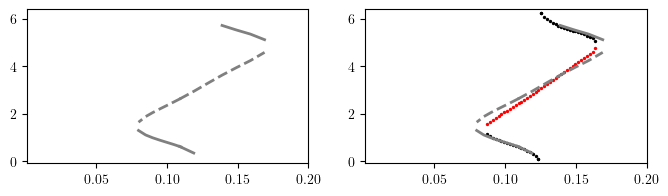

In [143]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [144]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.07999999999999997 1.2889160740875978
phi init 1.2889160740875978
Y [-1.17450842e-01  2.29689865e-01  7.17287203e-02  3.89714907e-01 -4.72241757e-01  6.53753244e-01  9.96890049e-02  5.94653741e-05  6.15876021e+00]
mkdir ./data/thal2_11_b0=-0.08/
* Loading LC data...
self.T 6.158760694295857
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004877386412061006
es_min,phi0 0.08049999999999997 1.2889160740875978
phi init 1.2889160740875978
Y [-1.17305111e-01  2.23413592e-01  7.17529938e-02  3.97742152e-01 -4.69208747e-01  6.54834417e-01  9.95829727e-02  5.52230240e-05  6.16227413e+00]
mkdir ./data/thal2_11_b1=-0.08/
* Loading LC data...
self.T 6.162274812721006
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.005781490158804786
es_min,phi0 0.08099999999999997 1.2889160740875978
phi init 1.2889160740875978
Y [-1.17214753e-01  2.29631947e-01  7.18178938e-02  3.90081428e-01 -4.67888683e-01  6.55350830e-01  9.95238372e-0

#### Monodromys max

In [145]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.16899999999999998 5.111012456010305
phi init 5.111012456010305
Y [-0.1013795   0.23338441  0.10672813  0.40458618 -0.56005858  0.15670521  0.05763796  0.09076787  6.23081666]
mkdir ./data/thal2_11_b0=-0.08/
* Loading LC data...
self.T 6.158760694295857
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.004877386412061006
es_min,phi0 0.16849999999999998 5.111012456010305
phi init 5.111012456010305
Y [-0.10131411  0.22709798  0.10648931  0.41165794 -0.55832103  0.15502047  0.05790856  0.09237241  6.2346237 ]
mkdir ./data/thal2_11_b1=-0.08/
* Loading LC data...
self.T 6.162274812721006
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.005781490158804786
es_min,phi0 0.16799999999999998 5.111012456010305
phi init 5.111012456010305
Y [-0.10122389  0.23217     0.10630282  0.40602668 -0.55455452  0.15108411  0.05817292  0.09634978  6.23811534]
mkdir ./data/thal2_11_b2=-0.08/
* Loading LC data...
self.T 6.165334050554165
l

In [146]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.1

#### Branches eps stable

In [147]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [148]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=1,eps_init=0.11,eps_final=0,deps=-.005),
            dict(phi0=1,eps_init=0.109,eps_final=0.21,deps=.005)]

In [149]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 1
phi init 1


In [150]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [151]:
kw_b['recompute'] = False
kw_b['b'] = b

In [152]:
# # get an initial condition for an unstable branch
# phis = np.linspace(0,1)
# for phi in phis:
#     dat,Yinit = follow_phase_diffs_u(**dict(phi0=phi,eps_init=0.079,eps_final=0.025,deps=-2),max_iter=100,return_point=True,**kw_b)

In [153]:
_,Yinit = follow_phase_diffs_u(**dict(phi0=3,eps_init=0.11,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

phi init 3
phase_diffs_u_init=3_nm=11_b=-0.1_ei=0.11_ef=0_de=-2.txt
phase_diffs_u_pt_init=3_nm=11_b=-0.1_ei=0.11_ef=0_de=-2.txt


In [154]:
#in_dicts = [dict(phi0=phi0,eps_init=0.01,eps_final=0.0,deps=-.01) for phi0 in np.linspace(4-1,4+1,10)]
in_dicts = [
    dict(phi0=4,eps_init=0.075,eps_final=0.07,deps=-.001),
    dict(phi0=4,eps_init=0.11,eps_final=0,deps=-.005),
    dict(phi0=4,eps_init=0.119,eps_final=0.21,deps=.01),
           ]

In [155]:
data_bu_list = []
# Y=Yinit
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 4
phase_diffs_u_init=4_nm=11_b=-0.1_ei=0.075_ef=0.07_de=-0.001.txt
phase_diffs_u_pt_init=4_nm=11_b=-0.1_ei=0.075_ef=0.07_de=-0.001.txt
phi init 4
phase_diffs_u_init=4_nm=11_b=-0.1_ei=0.11_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=4_nm=11_b=-0.1_ei=0.11_ef=0_de=-0.005.txt
phi init 4
phase_diffs_u_init=4_nm=11_b=-0.1_ei=0.119_ef=0.21_de=0.01.txt
phase_diffs_u_pt_init=4_nm=11_b=-0.1_ei=0.119_ef=0.21_de=0.01.txt


In [156]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

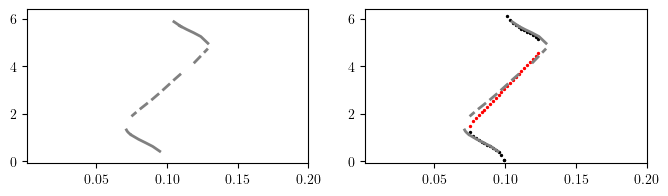

In [157]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [158]:
# get min eps
es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_min_temp = []
for i in range(5):
    ee = es_min+0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_min_temp.append(ee)

b_min_all.append(b)
eigenvalues_min_all.append(eigenvalues_temp)
e_vals_mono_min.append(es_min_temp)
#m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.071 1.3636135320365392
phi init 1.3636135320365392
Y [-1.16706691e-01  2.26800318e-01  7.36355901e-02  3.94264934e-01 -4.77411539e-01  6.51667534e-01  9.96971640e-02  6.77527410e-05  6.16253862e+00]
mkdir ./data/thal2_11_b0=-0.1/
* Loading LC data...
self.T 6.195901618457315
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01033419436619805
es_min,phi0 0.0715 1.3636135320365392
phi init 1.3636135320365392
Y [-1.16431362e-01  2.24398826e-01  7.37304500e-02  3.97590341e-01 -4.71967533e-01  6.53916854e-01  9.95009156e-02  5.88969771e-05  6.17016911e+00]
mkdir ./data/thal2_11_b1=-0.1/
* Loading LC data...
self.T 6.198579249335819
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01100899436127856
es_min,phi0 0.072 1.3636135320365392
phi init 1.3636135320365392
Y [-1.16228245e-01  2.27471631e-01  7.38492242e-02  3.94011754e-01 -4.68662511e-01  6.55161030e-01  9.93709730e-02  5.40944610e-05  6.17546403e+00]
mkdir ./da

#### Monodromys max

In [159]:
# get min eps
es_max,phi0 = get_es_max(data_bs_list,data_bu_list)


eigenvalues_temp = []
es_max_temp = []
for i in range(5):
    ee = es_max-0.0005*i
    m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
    eigenvalues_temp.append(m1.eigenvalues)
    es_max_temp.append(ee)

b_max_all.append(b)
eigenvalues_max_all.append(eigenvalues_temp)
e_vals_mono_max.append(es_max_temp)
#m1b = get_monodromy_full(es_max+.005,phi0[-1],a,b,mname=mname2.format(b))
# m1c = get_monodromy_full(es_max+.02,phi0[-1],a,b,mname=mname3.format(b))
#

#print(m1.eigenvalues)
#print(m1b.eigenvalues)

es_min,phi0 0.129 4.959599920690039
phi init 4.959599920690039
Y [-0.1036988   0.22844154  0.10407503  0.40777073 -0.58510213  0.18648637  0.06317573  0.06785192  6.20932633]
mkdir ./data/thal2_11_b0=-0.1/
* Loading LC data...
self.T 6.195901618457315
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01033419436619805
es_min,phi0 0.1285 4.959599920690039
phi init 4.959599920690039
Y [-0.10337998  0.22836238  0.10381093  0.40813045 -0.57798834  0.17572745  0.06344107  0.07525014  6.22044398]
mkdir ./data/thal2_11_b1=-0.1/
* Loading LC data...
self.T 6.198579249335819
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.01100899436127856
es_min,phi0 0.128 4.959599920690039
phi init 4.959599920690039
Y [-0.10318179  0.22768874  0.10355706  0.4090507  -0.57230602  0.16816323  0.06375067  0.08107521  6.22824799]
mkdir ./data/thal2_11_b2=-0.1/
* Loading LC data...
self.T 6.201156523514751
loaded coupling expansions
* Loading monodromy.

In [160]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [161]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

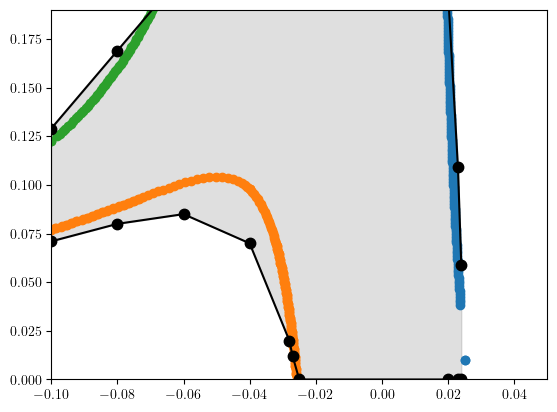

In [162]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

# split_idx = np.where(np.isnan(data[:,0]))[0][0]

# br1 = data[:split_idx]
# br2 = data[split_idx+1:]

# axs.plot(br1[:,0],br1[:,1],color='r',marker='.')
# axs.plot(br2[:,0],br2[:,1],color='r',marker='.')

axs.scatter(data[:,0],data[:,1])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

In [163]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

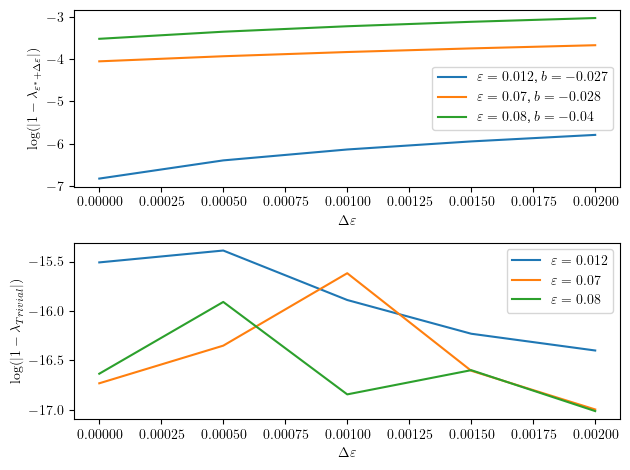

In [164]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 2

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

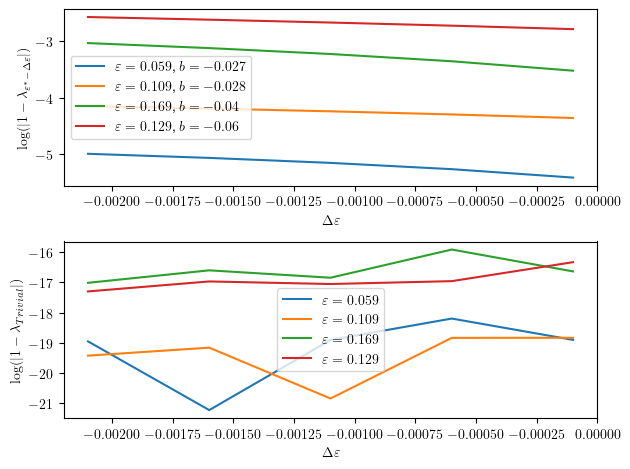

In [165]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_max_{}{}.png'.format(a._n[1],a._m[1]))